# Segment Anything - Fine-Tuning
## Fazendo fine-tuning em imagens de tumores cerebrais

---

Integrantes:
- João Gabriel
- Guilherme Buss
- Vinicius Nascimento

Matéria:
- Deep Learning - Dário

---

### Introdução

Para conseguir usar o SAM, precisamos baixar os modelos direto do repositório do facebookresearch, onde iremos pegar o modelo e já trazer todos os parâmetros do modelo.


In [ ]:
# biblioteca oficial do Segment Anything
!pip install git+https://github.com/facebookresearch/segment-anything.git

# dependências auxiliares
!pip install opencv-python pycocotools matplotlib onnxruntime onnx

# pesos do modelo
# ViT-B (Base) que é mais leve (~375MB).
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

print("Instalação concluída e pesos baixados!")

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-iwfbl12k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-iwfbl12k
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
Instalação concluída e pesos baixados!


# Printando o Modelo

In [ ]:
import torch
from segment_anything import sam_model_registry

# Configuração
MODEL_TYPE = "vit_b"
CHECKPOINT_PATH = "sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Usando dispositivo: {device}")

# carregando o modelo SAM
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device)

# Visão Geral
print("-" * 30)
print("ESTRUTURA GERAL DO SAM")
print("-" * 30)
for name, module in sam.named_children():
    print(f"Módulo: {name} | Tipo: {type(module).__name__}")

# Image Encoder (O ViT)
print("\n" + "-" * 30)
print("1. IMAGE ENCODER (Resumo)")
print("-" * 30)
print(sam.image_encoder)

# Prompt Encoder
print("\n" + "-" * 30)
print("2. PROMPT ENCODER")
print("-" * 30)
print(sam.prompt_encoder)

# Mask Decoder
print("\n" + "-" * 30)
print("3. MASK DECODER")
print("-" * 30)
print(sam.mask_decoder)

Usando dispositivo: cuda
------------------------------
ESTRUTURA GERAL DO SAM
------------------------------
Módulo: image_encoder | Tipo: ImageEncoderViT
Módulo: prompt_encoder | Tipo: PromptEncoder
Módulo: mask_decoder | Tipo: MaskDecoder

------------------------------
1. IMAGE ENCODER (Resumo)
------------------------------
ImageEncoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=768, out_features=3072, bias=True)
        (lin2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU(approximate='

# Fazendo o congelamento do Image Encoder e Prompt Encoder

O Image Encoder é muito pesado, e treinar ele, mesmo congelando várias camadas, seria muito complexo, ainda mais no Colab/Kaggle. Por isso, faremos fine-tuning no Mask Decoder

In [ ]:
# Congelando Image Encoder e Prompt Encoder
for param in sam.image_encoder.parameters():
    param.requires_grad = False
for param in sam.prompt_encoder.parameters():
    param.requires_grad = False

# Calculando parâmetros
total_params = sum(p.numel() for p in sam.parameters())
trainable_params = sum(p.numel() for p in sam.parameters() if p.requires_grad)

print(f"Total de Parâmetros: {total_params:,}")
print(f"Parâmetros Treináveis (Só Mask Decoder): {trainable_params:,}")
print(f"Percentual a treinar: {100 * trainable_params / total_params:.2f}%")

# Baixando o Dataset

Dataset escolhido foi um dataset de imagens de tumor cerebrais, com fotos e máscaras de diferentes tumores possíveis

In [ ]:
import os

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# baixando dataset -> link: atikaakter11/brain-tumor-segmentation-dataset
print("Baixando o dataset...")
!kaggle datasets download -d atikaakter11/brain-tumor-segmentation-dataset

print("Descompactando...")
!unzip -q brain-tumor-segmentation-dataset.zip -d dataset_tumor

print("Pasta 'dataset_tumor' criada.")

Baixando o dataset...
Dataset URL: https://www.kaggle.com/datasets/atikaakter11/brain-tumor-segmentation-dataset
License(s): MIT
brain-tumor-segmentation-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Descompactando...
replace dataset_tumor/Brain Tumor Segmentation Dataset/image/0/Tr-noTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
Pasta 'dataset_tumor' criada.


# Visualização de uma Imagem e sua Máscara

Aqui vemos se baixamos o dataset corretamente, além de definir o caminho para o diretório e fazer um mapeamento das classes.

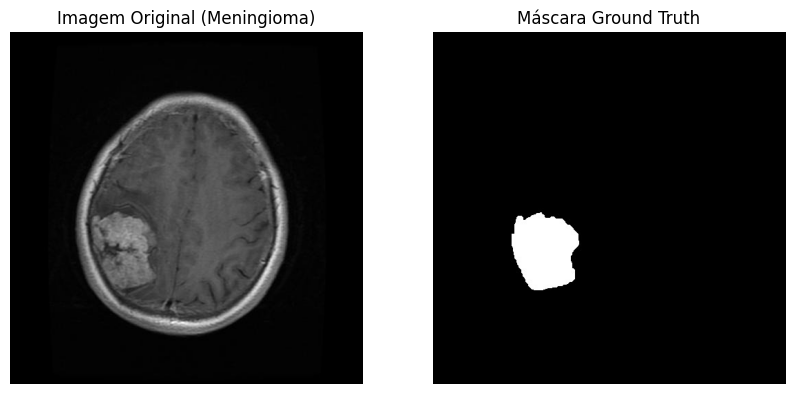

Arquivo visualizado: Tr-me_0010.jpg


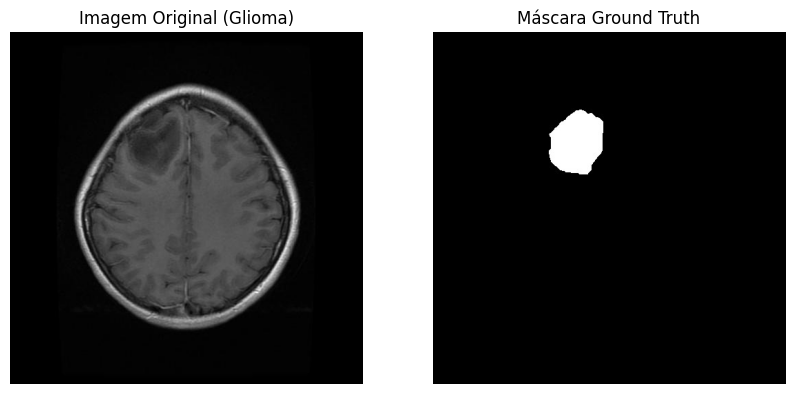

Arquivo visualizado: Tr-gl_0240.jpg


In [ ]:
import matplotlib.pyplot as plt
import cv2
import random
import glob

# Caminhos base
base_dir = 'dataset_tumor/Brain Tumor Segmentation Dataset'

# Mapeamento das classes
classes = {
    '0': 'No Tumor',
    '1': 'Glioma',
    '2': 'Meningioma',
    '3': 'Pituitary'
}

# Função para pegar uma imagem aleatória de uma classe específica
def visualizar_mascara(class_id):
    class_id = str(class_id)

    # glob para achar os arquivos jpg
    img_folder_path = os.path.join(base_dir, 'image', class_id)
    mask_folder_path = os.path.join(base_dir, 'mask', class_id)

    # listar todos os arquivos jpg
    all_images = glob.glob(os.path.join(img_folder_path, '*.jpg'))

    if not all_images:
        print(f"Nenhuma imagem encontrada para a classe {classes[class_id]} no caminho: {img_folder_path}")
        return

    # Pegando uma aleatória
    img_path = random.choice(all_images)
    filename = os.path.basename(img_path)
    mask_filename = os.path.splitext(filename)[0] + '_m.jpg'

    # Achar a máscara correspondente
    mask_path = os.path.join(mask_folder_path, mask_filename)

    if not os.path.exists(mask_path):
        print(f"Máscara não encontrada para: {mask_filename}")
        return

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Plotando a imagem e ground truth
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title(f"Imagem Original ({classes[class_id]})")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Máscara Ground Truth")
    ax[1].axis('off')

    plt.show()
    print(f"Arquivo visualizado: {filename}")

# Visualizando exemplo de Meningioma (Classe 2) e um de Glioma (Classe 1)
visualizar_mascara(2)
visualizar_mascara(1)

# Bounding Boxes para o Fine-Tuning do SAM

O SAM espera prompts e compara com máscaras binárias. Para treinar o SAM eficientemente, teremos que gerar Bounding Boxes a partir dessas máscaras para usar como prompt durante o treinamento.

In [ ]:
import numpy as np

def get_box_from_mask(mask_array):
    """
    Recebe uma máscara binária e retorna [x_min, y_min, x_max, y_max].
    Se a máscara for toda preta (sem tumor), retorna None
    """
    # np.where retorna dois arrays: índices Y (linhas) e índices X (colunas) onde a condição é verdadeira
    y_indices, x_indices = np.where(mask_array > 0)

    # Se não achou nenhum pixel branco (lista vazia), retorna None
    if len(y_indices) == 0:
        return None

    # Pegar os extremos
    x_min = np.min(x_indices)
    x_max = np.max(x_indices)
    y_min = np.min(y_indices)
    y_max = np.max(y_indices)

    # Retorna no formato padrão do SAM [x1, y1, x2, y2]
    return [x_min, y_min, x_max, y_max]

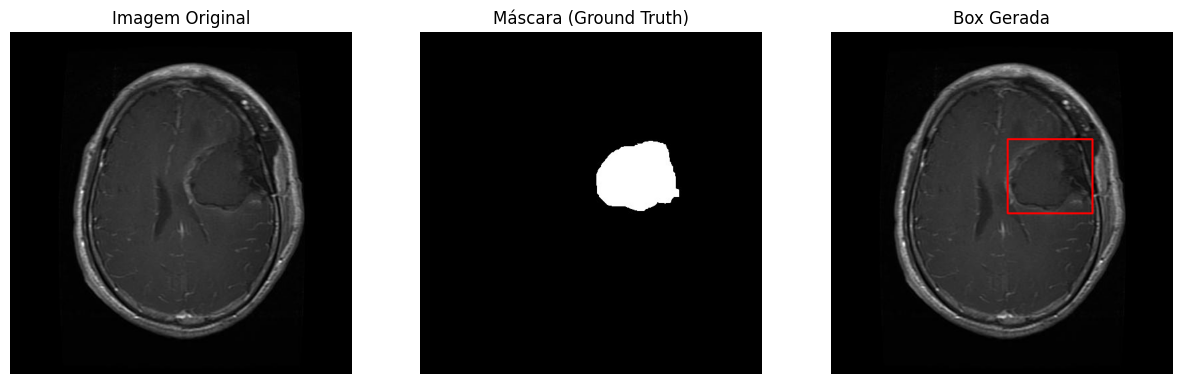

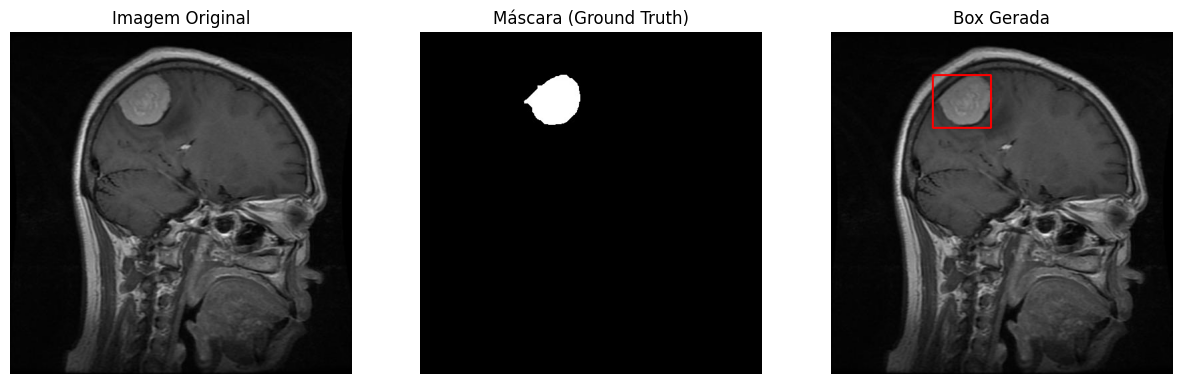

In [ ]:
def visualizar_box(base_dir, class_id='1'): # Default Glioma
    class_id = str(class_id)

    # glob para achar os arquivos jpg
    img_folder_path = os.path.join(base_dir, 'image', class_id)
    mask_folder_path = os.path.join(base_dir, 'mask', class_id)

    # listar todos os arquivos jpg
    all_images = glob.glob(os.path.join(img_folder_path, '*.jpg'))

    if not all_images:
        print(f"Nenhuma imagem encontrada para a classe {classes[class_id]} no caminho: {img_folder_path}")
        return

    # Pegando uma aleatória
    img_path = random.choice(all_images)
    filename = os.path.basename(img_path)
    mask_filename = os.path.splitext(filename)[0] + '_m.jpg'

    # Achar a máscara correspondente
    mask_path = os.path.join(mask_folder_path, mask_filename)

    if not os.path.exists(mask_path):
        print(f"Máscara não encontrada para: {mask_filename}")
        return

    # Carregar imagens e máscara em escala de cinza (0 a 255)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Criar a bounding box
    bbox = get_box_from_mask(mask)

    if bbox is None:
        print(f"Imagem {filename} não tem tumor (máscara vazia).")
        return

    x_min, y_min, x_max, y_max = bbox

    # Desenhar o retângulo na imagem (apenas para visualização)
    image_with_box = image.copy()
    cv2.rectangle(image_with_box, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Plotando
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(image)
    ax[0].set_title("Imagem Original")

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Máscara (Ground Truth)")

    ax[2].imshow(image_with_box)
    ax[2].set_title(f"Box Gerada")

    for a in ax: a.axis('off')
    plt.show()

visualizar_box(base_dir, '1')
visualizar_box(base_dir, '2')

# Configuração de Data Augmentation

Para evitar overfitting, vamos definir um pipeline de transformações "agressivas".
Usaremos a biblioteca `albumentations`. Note que não precisamos rotacionar as Bounding Boxes explicitamente aqui,
pois a nossa classe Dataset recalcula a box a partir da máscara *após* a transformação.

In [ ]:
import albumentations as A
import cv2

train_transform = A.Compose([
    # Espelhamento Horizontal
    A.HorizontalFlip(p=0.5),
    # Rotação
    A.Rotate(limit=10, p=0.3),
    # Ajustes sutis de iluminação/contraste
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
    # Ruído gaussiano bem leve para robustez contra artefatos
    A.GaussNoise(var_limit=(10.0, 30.0), p=0.1),
])

print("Pipeline de Augmentation LEVE definido.")

Pipeline de Augmentation LEVE definido.


/tmp/ipython-input-1958598724.py:16: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.1),


# Dataset

Aqui definimos o Dataset que terá as imagens e máscaras

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import os

class TumorDataset(Dataset):
    def __init__(self, root_dir, target_size=(256, 256), transform=None):
        self.root_dir = root_dir
        self.target_size = target_size
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        valid_classes = ['1', '2', '3']

        if not os.path.exists(os.path.join(root_dir, 'image')):
             for root, dirs, files in os.walk(root_dir):
                if 'image' in dirs:
                    root_dir = root
                    break

        self.base_path = root_dir

        for class_id in valid_classes:
            img_folder_path = os.path.join(self.base_path, 'image', class_id)
            mask_folder_path = os.path.join(self.base_path, 'mask', class_id)

            if not os.path.exists(img_folder_path):
                continue

            for filename in os.listdir(img_folder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(img_folder_path, filename)
                    filename = os.path.basename(img_path)
                    mask_filename = os.path.splitext(filename)[0] + '_m.jpg'
                    mask_path = os.path.join(mask_folder_path, mask_filename)

                    if os.path.exists(mask_path):
                        self.image_paths.append(img_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def get_box(self, mask_array):
        y_indices, x_indices = np.where(mask_array > 0)
        if len(y_indices) == 0:
            return None
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        return [x_min, y_min, x_max, y_max]

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # --- APLICAÇÃO DO DATA AUGMENTATION (Se existir) ---
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        # ---------------------------------------------------

        original_h, original_w = image.shape[:2]

        image_resized = cv2.resize(image, self.target_size)
        mask_resized = cv2.resize(mask, self.target_size, interpolation=cv2.INTER_NEAREST)

        # Recalcula Box na imagem já redimensionada
        box = self.get_box(mask_resized)

        if box is None:
            box = [0, 0, self.target_size[1], self.target_size[0]]

        image_tensor = torch.from_numpy(image_resized).permute(2, 0, 1).float() / 255.0
        mask_tensor = torch.from_numpy(mask_resized).unsqueeze(0).float() / 255.0
        mask_tensor = (mask_tensor > 0.5).float()
        box_tensor = torch.tensor(box).float()

        return {
            "image": image_tensor,
            "mask": mask_tensor,
            "box": box_tensor
        }

In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. Definir o diretório base (assumindo que 'base_dir' está definido)
print(f"Usando base_dir: {base_dir}")

# 2. Instanciar o Dataset DUAS vezes
dataset_augmented = TumorDataset(root_dir=base_dir, target_size=(256, 256), transform=train_transform)
dataset_clean     = TumorDataset(root_dir=base_dir, target_size=(256, 256), transform=None)

# 3. Estratégia de Divisão de Índices (80% Treino, 10% Val, 10% Teste)
dataset_size = len(dataset_augmented)
indices = list(range(dataset_size))

# Split 1: 80% Treino vs 20% Resto
train_indices, rest_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Split 2: 20% Resto -> 10% Validação e 10% Teste
val_indices, test_indices = train_test_split(rest_indices, test_size=0.5, random_state=42)

# 4. Criar os Subsets mapeando para a instância correta do dataset
train_dataset = Subset(dataset_augmented, train_indices) # Com Augmentation
val_dataset   = Subset(dataset_clean, val_indices)       # Sem Augmentation
test_dataset  = Subset(dataset_clean, test_indices)      # Sem Augmentation

print(f"Total de Imagens: {dataset_size}")
print(f"---")
print(f"Treino (Augmented): {len(train_dataset)} imagens")
print(f"Validação (Clean):  {len(val_dataset)} imagens")
print(f"Teste (Clean):      {len(test_dataset)} imagens")

# 5. Criar os 3 DataLoaders (batch_size=1 é obrigatório para SAM)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=1, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=1, shuffle=False)

Usando base_dir: dataset_tumor/Brain Tumor Segmentation Dataset
Total de Imagens: 2642
---
Treino (Augmented): 2113 imagens
Validação (Clean):  264 imagens
Teste (Clean):      265 imagens


# Começando com o Fine Tuning

---

Aqui já vamos usar o nosso Dataloader

In [ ]:
import numpy as np
import torch

class EarlyStopping:
    """
    Para o treinamento se a loss de validação não melhorar após 'patience' épocas.
    """
    def __init__(self, patience=3, min_delta=0, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.path = path
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} de {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.save_checkpoint(val_loss, model)
            self.best_loss = val_loss
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Salva o modelo quando a loss de validação diminui.'''
        print(f'Loss de validação melhorou ({self.best_loss:.6f} --> {val_loss:.6f}). Salvando modelo...')
        # Salva apenas o state_dict do mask_decoder para economizar espaço
        torch.save(model.mask_decoder.state_dict(), self.path)

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

for param in sam.image_encoder.parameters():
    param.requires_grad = False
for param in sam.prompt_encoder.parameters():
    param.requires_grad = False
for param in sam.mask_decoder.parameters():
    param.requires_grad = True

# Otimizador ADAM
optimizer = optim.AdamW(sam.mask_decoder.parameters(), lr=1e-4, weight_decay=1e-4)

# Scheduler: se não melhorar por n épocas, ele divide o LR por 10.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

print(f"Configuração atualizada: Patience={patience_early_stopping}, Scheduler Ativado.")

Configuração atualizada: Patience=10, Scheduler Ativado.


### Função de Loss DICE


In [ ]:
# Dice Loss (como pedido no trabalho...)
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # BCE Loss
        bce = F.binary_cross_entropy_with_logits(inputs, targets, reduction='mean')

        # Dice Loss
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return bce + (1 - dice)

loss_fn = DiceBCELoss()

# Correção de tamanho de imagem

In [ ]:
def ajustar_pos_embedding_sam(sam_model, target_size=256):
    """
    Redimensiona o positional embedding do SAM para aceitar imagens menores
    sem quebrar a arquitetura.
    """
    # Embedding original (que é 1x64x64x768 no ViT-B)
    pos_embed = sam_model.image_encoder.pos_embed
    print(f"Shape original do pos_embed: {pos_embed.shape}")

    # O formato é [1, H, W, C]. Precisamos mudar para [1, C, H, W] para interpolar
    pos_embed = pos_embed.permute(0, 3, 1, 2)
    new_grid_size = target_size // 16

    # Interpolar (Resize)
    new_pos_embed = F.interpolate(
        pos_embed,
        size=(new_grid_size, new_grid_size),
        mode='bicubic',
        align_corners=False
    )

    # Voltar para o formato original [1, H, W, C]
    new_pos_embed = new_pos_embed.permute(0, 2, 3, 1)
    sam_model.image_encoder.pos_embed = torch.nn.Parameter(new_pos_embed) # Substituindo no modelo
    print(f"Novo shape do pos_embed: {sam_model.image_encoder.pos_embed.shape}")
    print("Cirurgia concluída! O modelo agora aceita imagens 256x256.")

ajustar_pos_embedding_sam(sam, target_size=256)

# Ajustando o Prompt Encoder
target_size = 256
new_embed_size = target_size // 16

# Avisamos ao PromptEncoder que a imagem agora é 256x256 e embedding 16x16
sam.prompt_encoder.input_image_size = (target_size, target_size)
sam.prompt_encoder.image_embedding_size = (new_embed_size, new_embed_size)

print(f"Prompt Encoder ajustado para embeddings de tamanho: {sam.prompt_encoder.image_embedding_size}")

Shape original do pos_embed: torch.Size([1, 64, 64, 768])
Novo shape do pos_embed: torch.Size([1, 16, 16, 768])
Cirurgia concluída! O modelo agora aceita imagens 256x256.
Prompt Encoder ajustado para embeddings de tamanho: (16, 16)


# Loop de Treinamento

---

Aqui definimos o loop de treinamento:
- Congelamos o Image Encoder e o Prompt Encoder
- Os usamos para pegar os embeddings das imagens e das bounding boxes
- Passamos isso para o Mask Decoder (que ter atualização de gradiente)

In [ ]:
from tqdm import tqdm

# -----------------------------------------------------------------------------
# Configurações do Treinamento
# -----------------------------------------------------------------------------
num_epochs = 20
patience = 3   # Se não melhorar por 3 épocas seguidas, para.
best_model_path = "mask_decoder_best.pth"

early_stopping = EarlyStopping(patience=patience, path=best_model_path)

train_losses = []
val_losses = []

print("Iniciando treinamento com Early Stopping...")

for epoch in range(num_epochs):
    # ===========================
    # Fase de TREINO
    # ===========================
    sam.mask_decoder.train()
    train_loss_accum = 0

    # Barra de progresso
    loop_train = tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs} [Treino]")

    for batch in loop_train:
        images = batch['image'].to(device)
        masks = batch['mask'].to(device)
        boxes = batch['box'].to(device)

        # Forward pass
        with torch.no_grad():
            image_embedding = sam.image_encoder(images)
            box_torch = boxes.unsqueeze(1)
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None, boxes=box_torch, masks=None,
            )

        # Lógica de Positional Embedding (PE)
        batch_size, _, h, w = image_embedding.shape
        image_pe = sam.prompt_encoder.get_dense_pe()
        if image_pe.shape[2] != h or image_pe.shape[3] != w:
            image_pe = F.interpolate(image_pe, size=(h, w), mode='bilinear', align_corners=False)

        # Decoder
        low_res_masks, _ = sam.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=image_pe,
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        # Upscale e Loss
        upscaled_masks = F.interpolate(low_res_masks, size=(256, 256), mode="bilinear", align_corners=False)
        loss = loss_fn(upscaled_masks, masks)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_accum += loss.item()
        loop_train.set_postfix(loss=loss.item())

    avg_train_loss = train_loss_accum / len(train_loader)
    train_losses.append(avg_train_loss)

    # ===========================
    # Fase de VALIDAÇÃO
    # ===========================
    sam.mask_decoder.eval()
    val_loss_accum = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            boxes = batch['box'].to(device)

            # Forward pass igual ao treino, mas sem calcular gradiente
            image_embedding = sam.image_encoder(images)
            box_torch = boxes.unsqueeze(1)
            sparse_embeddings, dense_embeddings = sam.prompt_encoder(
                points=None, boxes=box_torch, masks=None,
            )

            batch_size, _, h, w = image_embedding.shape
            image_pe = sam.prompt_encoder.get_dense_pe()
            if image_pe.shape[2] != h or image_pe.shape[3] != w:
                image_pe = F.interpolate(image_pe, size=(h, w), mode='bilinear', align_corners=False)

            low_res_masks, _ = sam.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=image_pe,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            upscaled_masks = F.interpolate(low_res_masks, size=(256, 256), mode="bilinear", align_corners=False)
            loss = loss_fn(upscaled_masks, masks)
            val_loss_accum += loss.item()

    avg_val_loss = val_loss_accum / len(val_loader)
    val_losses.append(avg_val_loss)

    # ===========================
    # Log e Early Stopping
    # ===========================
    print(f"\nRESUMO ÉPOCA {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # Verifica se deve parar ou salvar
    early_stopping(avg_val_loss, sam)

    if early_stopping.early_stop:
        print("\n⏹ Parada Antecipada (Early Stopping) acionada!")
        break

print("\nTreinamento Finalizado.")

# Carregar o melhor modelo salvo pelo Early Stopping
print(f"Carregando o melhor modelo salvo em: {best_model_path}")
sam.mask_decoder.load_state_dict(torch.load(best_model_path))

Iniciando treinamento com Early Stopping...


Época 1/30 [Treino]: 100%|██████████| 2113/2113 [02:07<00:00, 16.57it/s, loss=0.117]



RESUMO ÉPOCA 1: Train Loss: 0.1051 | Val Loss: 0.0877
Loss de validação melhorou (0.087662 --> 0.087662). Salvando modelo...


Época 2/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.27it/s, loss=0.108]



RESUMO ÉPOCA 2: Train Loss: 0.0947 | Val Loss: 0.0861
Loss de validação melhorou (0.087662 --> 0.086147). Salvando modelo...


Época 3/30 [Treino]: 100%|██████████| 2113/2113 [02:01<00:00, 17.38it/s, loss=0.0976]



RESUMO ÉPOCA 3: Train Loss: 0.0917 | Val Loss: 0.0891
EarlyStopping counter: 1 de 5


Época 4/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.26it/s, loss=0.201]



RESUMO ÉPOCA 4: Train Loss: 0.0884 | Val Loss: 0.0857
Loss de validação melhorou (0.086147 --> 0.085706). Salvando modelo...


Época 5/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.19it/s, loss=0.0479]



RESUMO ÉPOCA 5: Train Loss: 0.0872 | Val Loss: 0.0835
Loss de validação melhorou (0.085706 --> 0.083471). Salvando modelo...


Época 6/30 [Treino]: 100%|██████████| 2113/2113 [02:03<00:00, 17.16it/s, loss=0.0537]



RESUMO ÉPOCA 6: Train Loss: 0.0849 | Val Loss: 0.0839
EarlyStopping counter: 1 de 5


Época 7/30 [Treino]: 100%|██████████| 2113/2113 [02:01<00:00, 17.38it/s, loss=0.0595]



RESUMO ÉPOCA 7: Train Loss: 0.0839 | Val Loss: 0.0811
Loss de validação melhorou (0.083471 --> 0.081148). Salvando modelo...


Época 8/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.19it/s, loss=0.0314]



RESUMO ÉPOCA 8: Train Loss: 0.0815 | Val Loss: 0.0840
EarlyStopping counter: 1 de 5


Época 9/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.31it/s, loss=0.0826]



RESUMO ÉPOCA 9: Train Loss: 0.0808 | Val Loss: 0.0785
Loss de validação melhorou (0.081148 --> 0.078489). Salvando modelo...


Época 10/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.25it/s, loss=0.0445]



RESUMO ÉPOCA 10: Train Loss: 0.0786 | Val Loss: 0.0812
EarlyStopping counter: 1 de 5


Época 11/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.28it/s, loss=0.0382]



RESUMO ÉPOCA 11: Train Loss: 0.0783 | Val Loss: 0.0788
EarlyStopping counter: 2 de 5


Época 12/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.18it/s, loss=0.0294]



RESUMO ÉPOCA 12: Train Loss: 0.0779 | Val Loss: 0.0769
Loss de validação melhorou (0.078489 --> 0.076890). Salvando modelo...


Época 13/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.31it/s, loss=0.041]



RESUMO ÉPOCA 13: Train Loss: 0.0771 | Val Loss: 0.0766
Loss de validação melhorou (0.076890 --> 0.076559). Salvando modelo...


Época 14/30 [Treino]: 100%|██████████| 2113/2113 [02:03<00:00, 17.17it/s, loss=0.0707]



RESUMO ÉPOCA 14: Train Loss: 0.0760 | Val Loss: 0.0820
EarlyStopping counter: 1 de 5


Época 15/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.20it/s, loss=0.0253]



RESUMO ÉPOCA 15: Train Loss: 0.0750 | Val Loss: 0.0822
EarlyStopping counter: 2 de 5


Época 16/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.29it/s, loss=0.0445]



RESUMO ÉPOCA 16: Train Loss: 0.0744 | Val Loss: 0.0788
EarlyStopping counter: 3 de 5


Época 17/30 [Treino]: 100%|██████████| 2113/2113 [02:03<00:00, 17.13it/s, loss=0.106]



RESUMO ÉPOCA 17: Train Loss: 0.0735 | Val Loss: 0.0769
EarlyStopping counter: 4 de 5


Época 18/30 [Treino]: 100%|██████████| 2113/2113 [02:02<00:00, 17.22it/s, loss=0.0577]



RESUMO ÉPOCA 18: Train Loss: 0.0734 | Val Loss: 0.0768
EarlyStopping counter: 5 de 5

⏹ Parada Antecipada (Early Stopping) acionada!

Treinamento Finalizado.
Carregando o melhor modelo salvo em: mask_decoder_best.pth


<All keys matched successfully>

In [ ]:
print("Salvando o modelo treinado")
CHECKPOINT_NAME = "mask_decoder.pth"
torch.save(sam.mask_decoder.state_dict(), CHECKPOINT_NAME)

print(f"Modelo salvo como '{CHECKPOINT_NAME}'")
try:
    from google.colab import files
    files.download(CHECKPOINT_NAME)
    print("Download iniciado no navegador.")
except ImportError:
    print("Arquivo salvo localmente.")

Salvando o modelo treinado
Modelo salvo como 'mask_decoder.pth'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download iniciado no navegador.


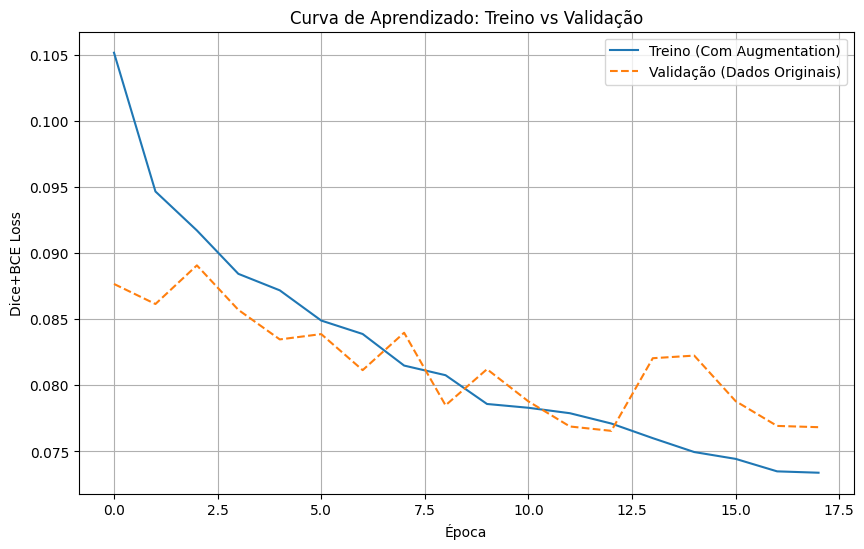

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Treino (Com Augmentation)')
plt.plot(val_losses, label='Validação (Dados Originais)', linestyle='--')
plt.title("Curva de Aprendizado: Treino vs Validação")
plt.xlabel("Época")
plt.ylabel("Dice+BCE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from segment_anything import sam_model_registry

# ----------------------------------------------------------
# 1) SAM ORIGINAL (pré-treinado, sem fine-tuning!)
# ----------------------------------------------------------
sam_original = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device)

# Ajusta para trabalhar com imagens 256x256 (igual fizemos previamente)
ajustar_pos_embedding_sam(sam_original, target_size=256)
sam_original.prompt_encoder.input_image_size = (256, 256)
sam_original.prompt_encoder.image_embedding_size = (256 // 16, 256 // 16)

print("SAM original carregado")

# ----------------------------------------------------------
# 2) SAM FINE-TUNED (nosso modelo, com o Mask Decoder novo)
# ----------------------------------------------------------
sam_finetuned = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device)

# Mesmo ajuste de tamanho
ajustar_pos_embedding_sam(sam_finetuned, target_size=256)
sam_finetuned.prompt_encoder.input_image_size = (256, 256)
sam_finetuned.prompt_encoder.image_embedding_size = (256 // 16, 256 // 16)

# Carregando os pesos que treinamos
decoder_state_dict = torch.load("mask_decoder.pth", map_location=device)

try:
    sam_finetuned.mask_decoder.load_state_dict(decoder_state_dict, strict=True)
    print("Pesos do mask_decoder carregados (strict=True).")
except RuntimeError as e:
    print("Erro ao carregar com strict=True:", e)
    print("   Tentando carregar com strict=False...")
    sam_finetuned.mask_decoder.load_state_dict(decoder_state_dict, strict=False)
    print("Pesos do mask_decoder carregados.")

print("SAM fine-tuned preparado.")


Shape original do pos_embed: torch.Size([1, 64, 64, 768])
Novo shape do pos_embed: torch.Size([1, 16, 16, 768])
Cirurgia concluída! O modelo agora aceita imagens 256x256.
✔ SAM original carregado.
Shape original do pos_embed: torch.Size([1, 64, 64, 768])
Novo shape do pos_embed: torch.Size([1, 16, 16, 768])
Cirurgia concluída! O modelo agora aceita imagens 256x256.
✔ Pesos do mask_decoder carregados (strict=True).
✔ SAM fine-tuned preparado (com mask_decoder.pth).


# Comparação e Análise de Resultados

Nesta seção, realizaremos a etapa crítica do trabalho: comparar objetivamente o desempenho do **SAM Original (Zero-Shot)** contra o **SAM Fine-Tuned**.

O objetivo é responder:
1. O modelo pré-treinado generalista consegue segmentar tumores apenas com prompts de caixa?
2. O fine-tuning no decoder melhorou a aderência da máscara às bordas do tumor?
3. Qual o ganho quantitativo em métricas de IoU (Intersection over Union)?

Iniciando avaliação em 264 imagens de teste...

RESULTADOS FINAIS DA AVALIAÇÃO
📉 Loss Média (Dice+BCE): 0.0766
🎯 IoU Médio (Precisão):    87.84%


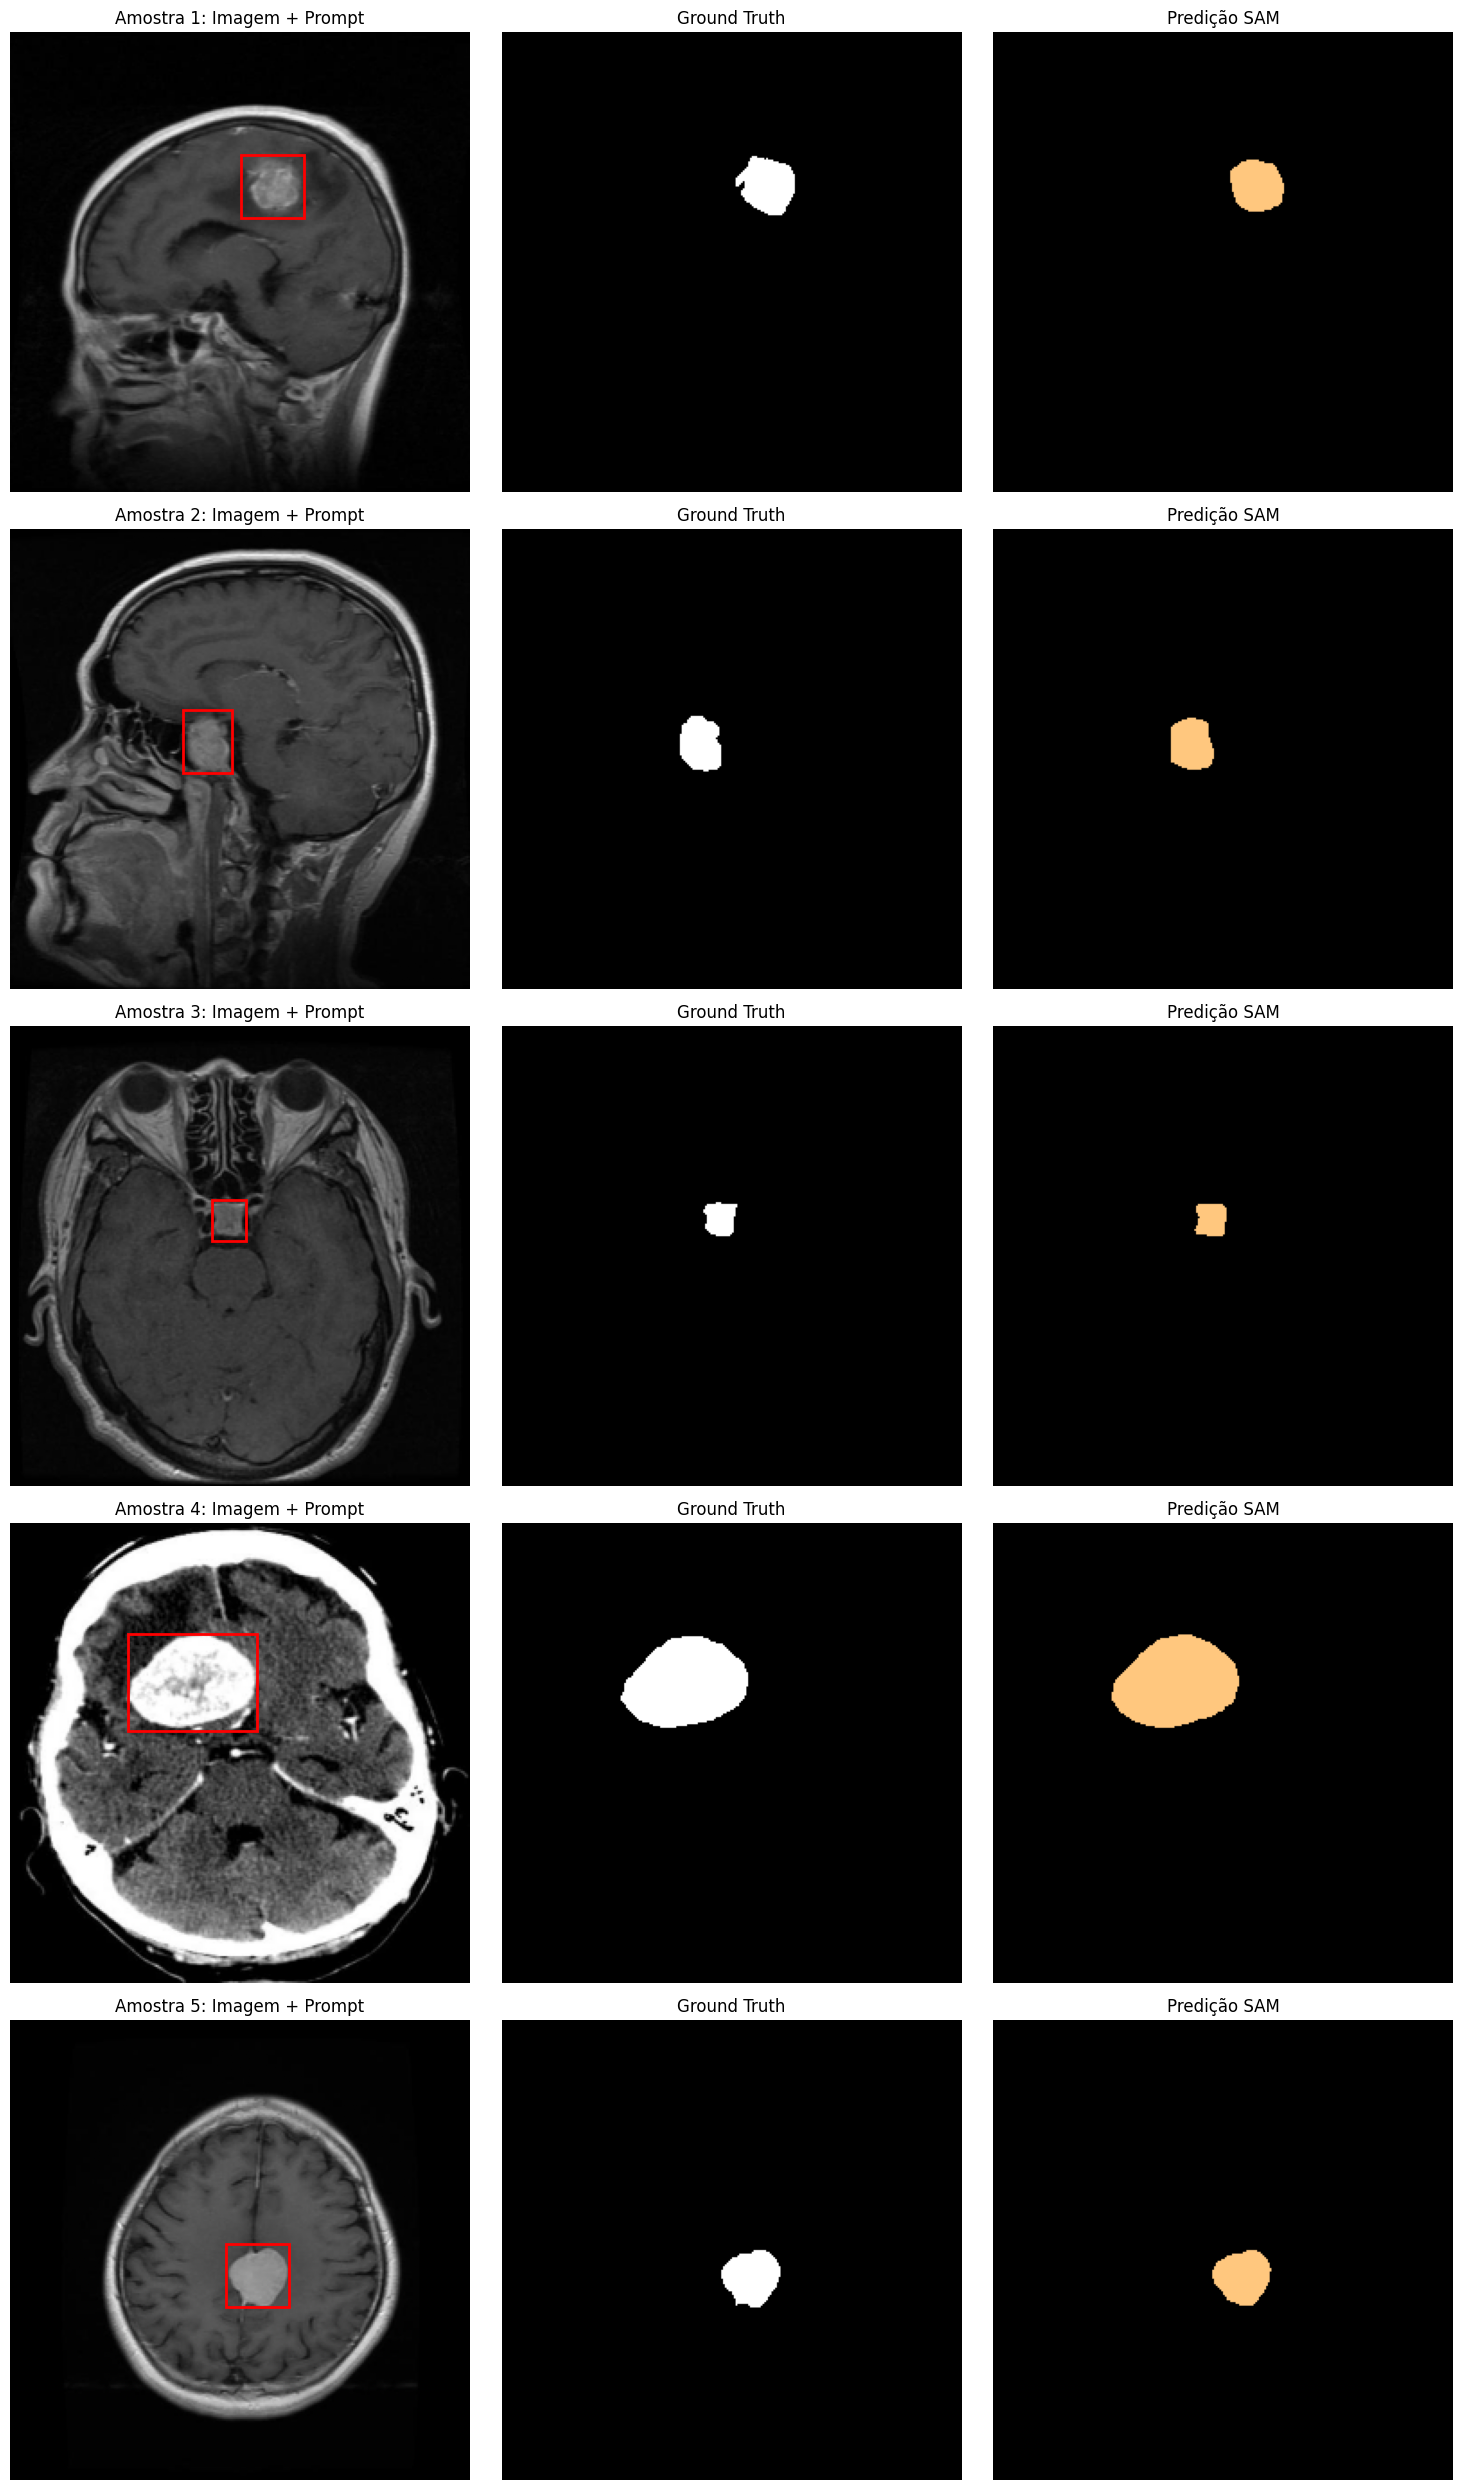

In [ ]:
import matplotlib.patches as patches

def calculate_iou(pred_mask, gt_mask):
    # Pred_mask e gt_mask devem ser binários (0 ou 1)
    intersection = (pred_mask * gt_mask).sum()
    union = pred_mask.sum() + gt_mask.sum() - intersection

    if union == 0:
        return 1.0
    return intersection / union

def avaliar_modelo_completo(sam_model, val_loader, device, loss_fn, num_visualizacoes=5):
    sam_model.eval()

    total_loss = 0
    total_iou = 0
    num_batches = 0

    # Lista para guardar exemplos para plotar depois
    exemplos_para_plotar = []

    print(f"Iniciando avaliação em {len(val_loader.dataset)} imagens de teste...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            boxes = batch['box'].to(device)

            # Image Encoder
            image_embedding = sam_model.image_encoder(images)

            # Prompt Encoder
            box_torch = boxes.unsqueeze(1)
            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=box_torch,
                masks=None,
            )

            # Mask Decoder
            batch_size, embed_dim, h, w = image_embedding.shape
            image_pe = sam_model.prompt_encoder.get_dense_pe()
            if image_pe.shape[2] != h or image_pe.shape[3] != w:
                image_pe = F.interpolate(image_pe, size=(h, w), mode='bilinear', align_corners=False)

            low_res_masks, _ = sam_model.mask_decoder(
                image_embeddings=image_embedding,
                image_pe=image_pe,
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=False,
            )

            # Upscale e Probabilidade
            upscaled_masks = F.interpolate(
                low_res_masks,
                size=(256, 256),
                mode="bilinear",
                align_corners=False
            )

            # Loss
            loss = loss_fn(upscaled_masks, masks)
            total_loss += loss.item()

            # Predição Binária para IoU e Visualização
            pred_masks_bin = (torch.sigmoid(upscaled_masks) > 0.5).float()

            # Calcular IoU médio do batch
            batch_iou = calculate_iou(pred_masks_bin, masks)
            total_iou += batch_iou.item()
            num_batches += 1

            # Pegando alguns exemplos para plotar e ver se segmentamos bem
            current_batch_size = images.shape[0]
            for i in range(current_batch_size):
                if len(exemplos_para_plotar) < num_visualizacoes:
                    exemplos_para_plotar.append({
                        'image': images[i].cpu(),
                        'gt': masks[i].cpu(),
                        'pred': pred_masks_bin[i].cpu(),
                        'box': boxes[i].cpu()
                    })

    # --- MÉTRICAS FINAIS ---
    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches

    print("\n" + "="*40)
    print(f"RESULTADOS FINAIS DA AVALIAÇÃO")
    print("="*40)
    print(f"📉 Loss Média (Dice+BCE): {avg_loss:.4f}")
    print(f"🎯 IoU Médio (Precisão):    {avg_iou:.2%}")
    print("="*40)

    # --- PLOTAGEM DO GRID ---
    if len(exemplos_para_plotar) > 0:
        fig, axs = plt.subplots(len(exemplos_para_plotar), 3, figsize=(15, 5 * len(exemplos_para_plotar)))
        if len(exemplos_para_plotar) == 1: axs = [axs]

        for idx, sample in enumerate(exemplos_para_plotar):
            img = sample['image'].permute(1, 2, 0).numpy()
            gt = sample['gt'].squeeze().numpy()
            pred = sample['pred'].squeeze().numpy()
            box = sample['box'].numpy()

            # Coluna 1: Imagem + Prompt
            axs[idx][0].imshow(img)
            rect = patches.Rectangle(
                (box[0], box[1]), box[2]-box[0], box[3]-box[1],
                linewidth=2, edgecolor='red', facecolor='none'
            )
            axs[idx][0].add_patch(rect)
            axs[idx][0].set_title(f"Amostra {idx+1}: Imagem + Prompt")
            axs[idx][0].axis('off')

            # Coluna 2: Ground Truth
            axs[idx][1].imshow(gt, cmap='gray')
            axs[idx][1].set_title("Ground Truth")
            axs[idx][1].axis('off')

            # Coluna 3: Predição
            axs[idx][2].imshow(pred, cmap='copper')
            axs[idx][2].set_title("Predição SAM")
            axs[idx][2].axis('off')

        plt.tight_layout()
        plt.show()

# Fazendo avaliação
avaliacao_teste_completa = avaliar_modelo_completo(sam, val_loader, device, loss_fn, num_visualizacoes=5)

In [ ]:
def comparar_modelos(model_original, model_finetuned, dataloader, device, num_samples=5):
    """
    Executa inferência em ambos os modelos para o mesmo batch e compara resultados.
    Retorna métricas globais e lista de amostras para visualização.
    """
    model_original.eval()
    model_finetuned.eval()

    ious_original = []
    ious_finetuned = []
    samples_viz = []

    print(f"Comparando modelos em {len(dataloader.dataset)} imagens...")

    with torch.no_grad():
        for batch_idx, batch in enumerate(dataloader):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)
            boxes = batch['box'].to(device)

            # ==================================================
            # Image Encoder & Prompt Encoder
            # ==================================================
            emb_orig = model_original.image_encoder(images)
            box_torch = boxes.unsqueeze(1)
            sparse_emb_orig, dense_emb_orig = model_original.prompt_encoder(
                points=None, boxes=box_torch, masks=None
            )

            # Ajuste de PE (Positional Encoding) para resolução 256 (mesma lógica do treino)
            batch_size, _, h, w = emb_orig.shape
            image_pe = model_original.prompt_encoder.get_dense_pe()
            if image_pe.shape[2] != h or image_pe.shape[3] != w:
                image_pe = F.interpolate(image_pe, size=(h, w), mode='bilinear', align_corners=False)

            low_res_masks_orig, _ = model_original.mask_decoder(
                image_embeddings=emb_orig,
                image_pe=image_pe,
                sparse_prompt_embeddings=sparse_emb_orig,
                dense_prompt_embeddings=dense_emb_orig,
                multimask_output=False,
            )

            # Upscale e Binarização Original
            mask_orig_up = F.interpolate(low_res_masks_orig, size=(256, 256), mode="bilinear", align_corners=False)
            pred_orig = (torch.sigmoid(mask_orig_up) > 0.5).float()

            # ==============================
            # MODELO FINE-TUNED
            # ==============================
            emb_ft = model_finetuned.image_encoder(images)
            sparse_emb_ft, dense_emb_ft = model_finetuned.prompt_encoder(
                points=None, boxes=box_torch, masks=None
            )

            low_res_masks_ft, _ = model_finetuned.mask_decoder(
                image_embeddings=emb_ft,
                image_pe=image_pe,
                sparse_prompt_embeddings=sparse_emb_ft,
                dense_prompt_embeddings=dense_emb_ft,
                multimask_output=False,
            )

            # Upscale e Binarização do Fine-Tuned
            mask_ft_up = F.interpolate(low_res_masks_ft, size=(256, 256), mode="bilinear", align_corners=False)
            pred_ft = (torch.sigmoid(mask_ft_up) > 0.5).float()

            # ==================================================
            # CÁLCULO DE MÉTRICAS
            # ==================================================
            iou_orig = calculate_iou(pred_orig, masks).item()
            iou_ft = calculate_iou(pred_ft, masks).item()

            ious_original.append(iou_orig)
            ious_finetuned.append(iou_ft)

            # Guardar amostras para plotar (apenas as primeiras 'num_samples')
            if len(samples_viz) < num_samples:
                samples_viz.append({
                    'image': images[0].cpu(),
                    'gt': masks[0].cpu(),
                    'box': boxes[0].cpu(),
                    'pred_orig': pred_orig[0].cpu(),
                    'pred_ft': pred_ft[0].cpu(),
                    'iou_orig': iou_orig,
                    'iou_ft': iou_ft
                })

    return ious_original, ious_finetuned, samples_viz

In [ ]:
import pandas as pd

# Executando a comparação
iou_list_orig, iou_list_ft, visualizacoes = comparar_modelos(
    sam_original,
    sam_finetuned,
    test_loader,
    device,
    num_samples=5
)

# Criando DataFrame para exibição limpa
df_results = pd.DataFrame({
    'Métrica': ['Média IoU', 'Desvio Padrão IoU', 'IoU Máximo', 'IoU Mínimo'],
    'SAM Original (Zero-Shot)': [
        np.mean(iou_list_orig),
        np.std(iou_list_orig),
        np.max(iou_list_orig),
        np.min(iou_list_orig)
    ],
    'SAM Fine-Tuned': [
        np.mean(iou_list_ft),
        np.std(iou_list_ft),
        np.max(iou_list_ft),
        np.min(iou_list_ft)
    ]
})

Comparando modelos em 265 imagens...


### Resultados Quantitativos

A tabela abaixo demonstra a diferença de performance média em todo o conjunto de validação.

- **Zero-Shot:** O desempenho esperado é inferior, pois o modelo original foi treinado em objetos naturais (carros, pessoas, animais) e não possui conhecimento específico sobre texturas de ressonância magnética.
- **Fine-Tuned:** Espera-se um aumento significativo no IoU, indicando que o decoder aprendeu a interpretar as features do *Encoder* especificamente para delimitar tumores.

COMPARATIVO FINAL DE PERFORMANCE
             Métrica  SAM Original (Zero-Shot)  SAM Fine-Tuned
0          Média IoU                    0.7891          0.8775
1  Desvio Padrão IoU                    0.1229          0.0706
2         IoU Máximo                    0.9606          0.9829
3         IoU Mínimo                    0.2826          0.5685


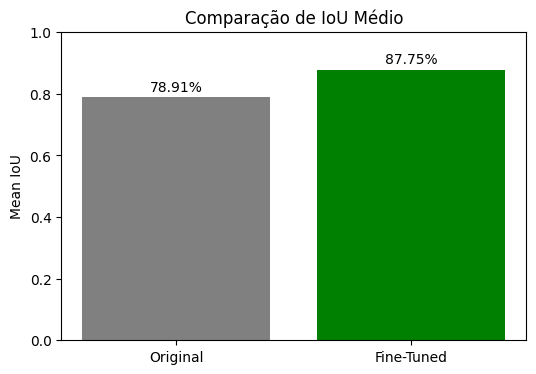

In [ ]:
# Exibindo tabela de resultados
print("="*60)
print("COMPARATIVO FINAL DE PERFORMANCE")
print("="*60)
print(df_results.round(4))
print("="*60)

# Gráfico de barras comparativo
medias = [np.mean(iou_list_orig), np.mean(iou_list_ft)]
labels = ['Original', 'Fine-Tuned']

plt.figure(figsize=(6, 4))
bars = plt.bar(labels, medias, color=['gray', 'green'])
plt.ylabel('Mean IoU')
plt.title('Comparação de IoU Médio')
plt.ylim(0, 1.0)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2%}", ha='center', va='bottom')

plt.show()

### Resultados Qualitativos (Visualização)

Abaixo comparamos visualmente as máscaras geradas.

- **Coluna 1:** Imagem original com a Bounding Box (Prompt).
- **Coluna 2:** Ground Truth (O que o médico marcou).
- **Coluna 3:** SAM Original (Geralmente tenta segmentar regiões maiores ou se perde no contraste baixo).
- **Coluna 4:** SAM Fine-Tuned (Deve seguir contornos mais precisos do tumor).

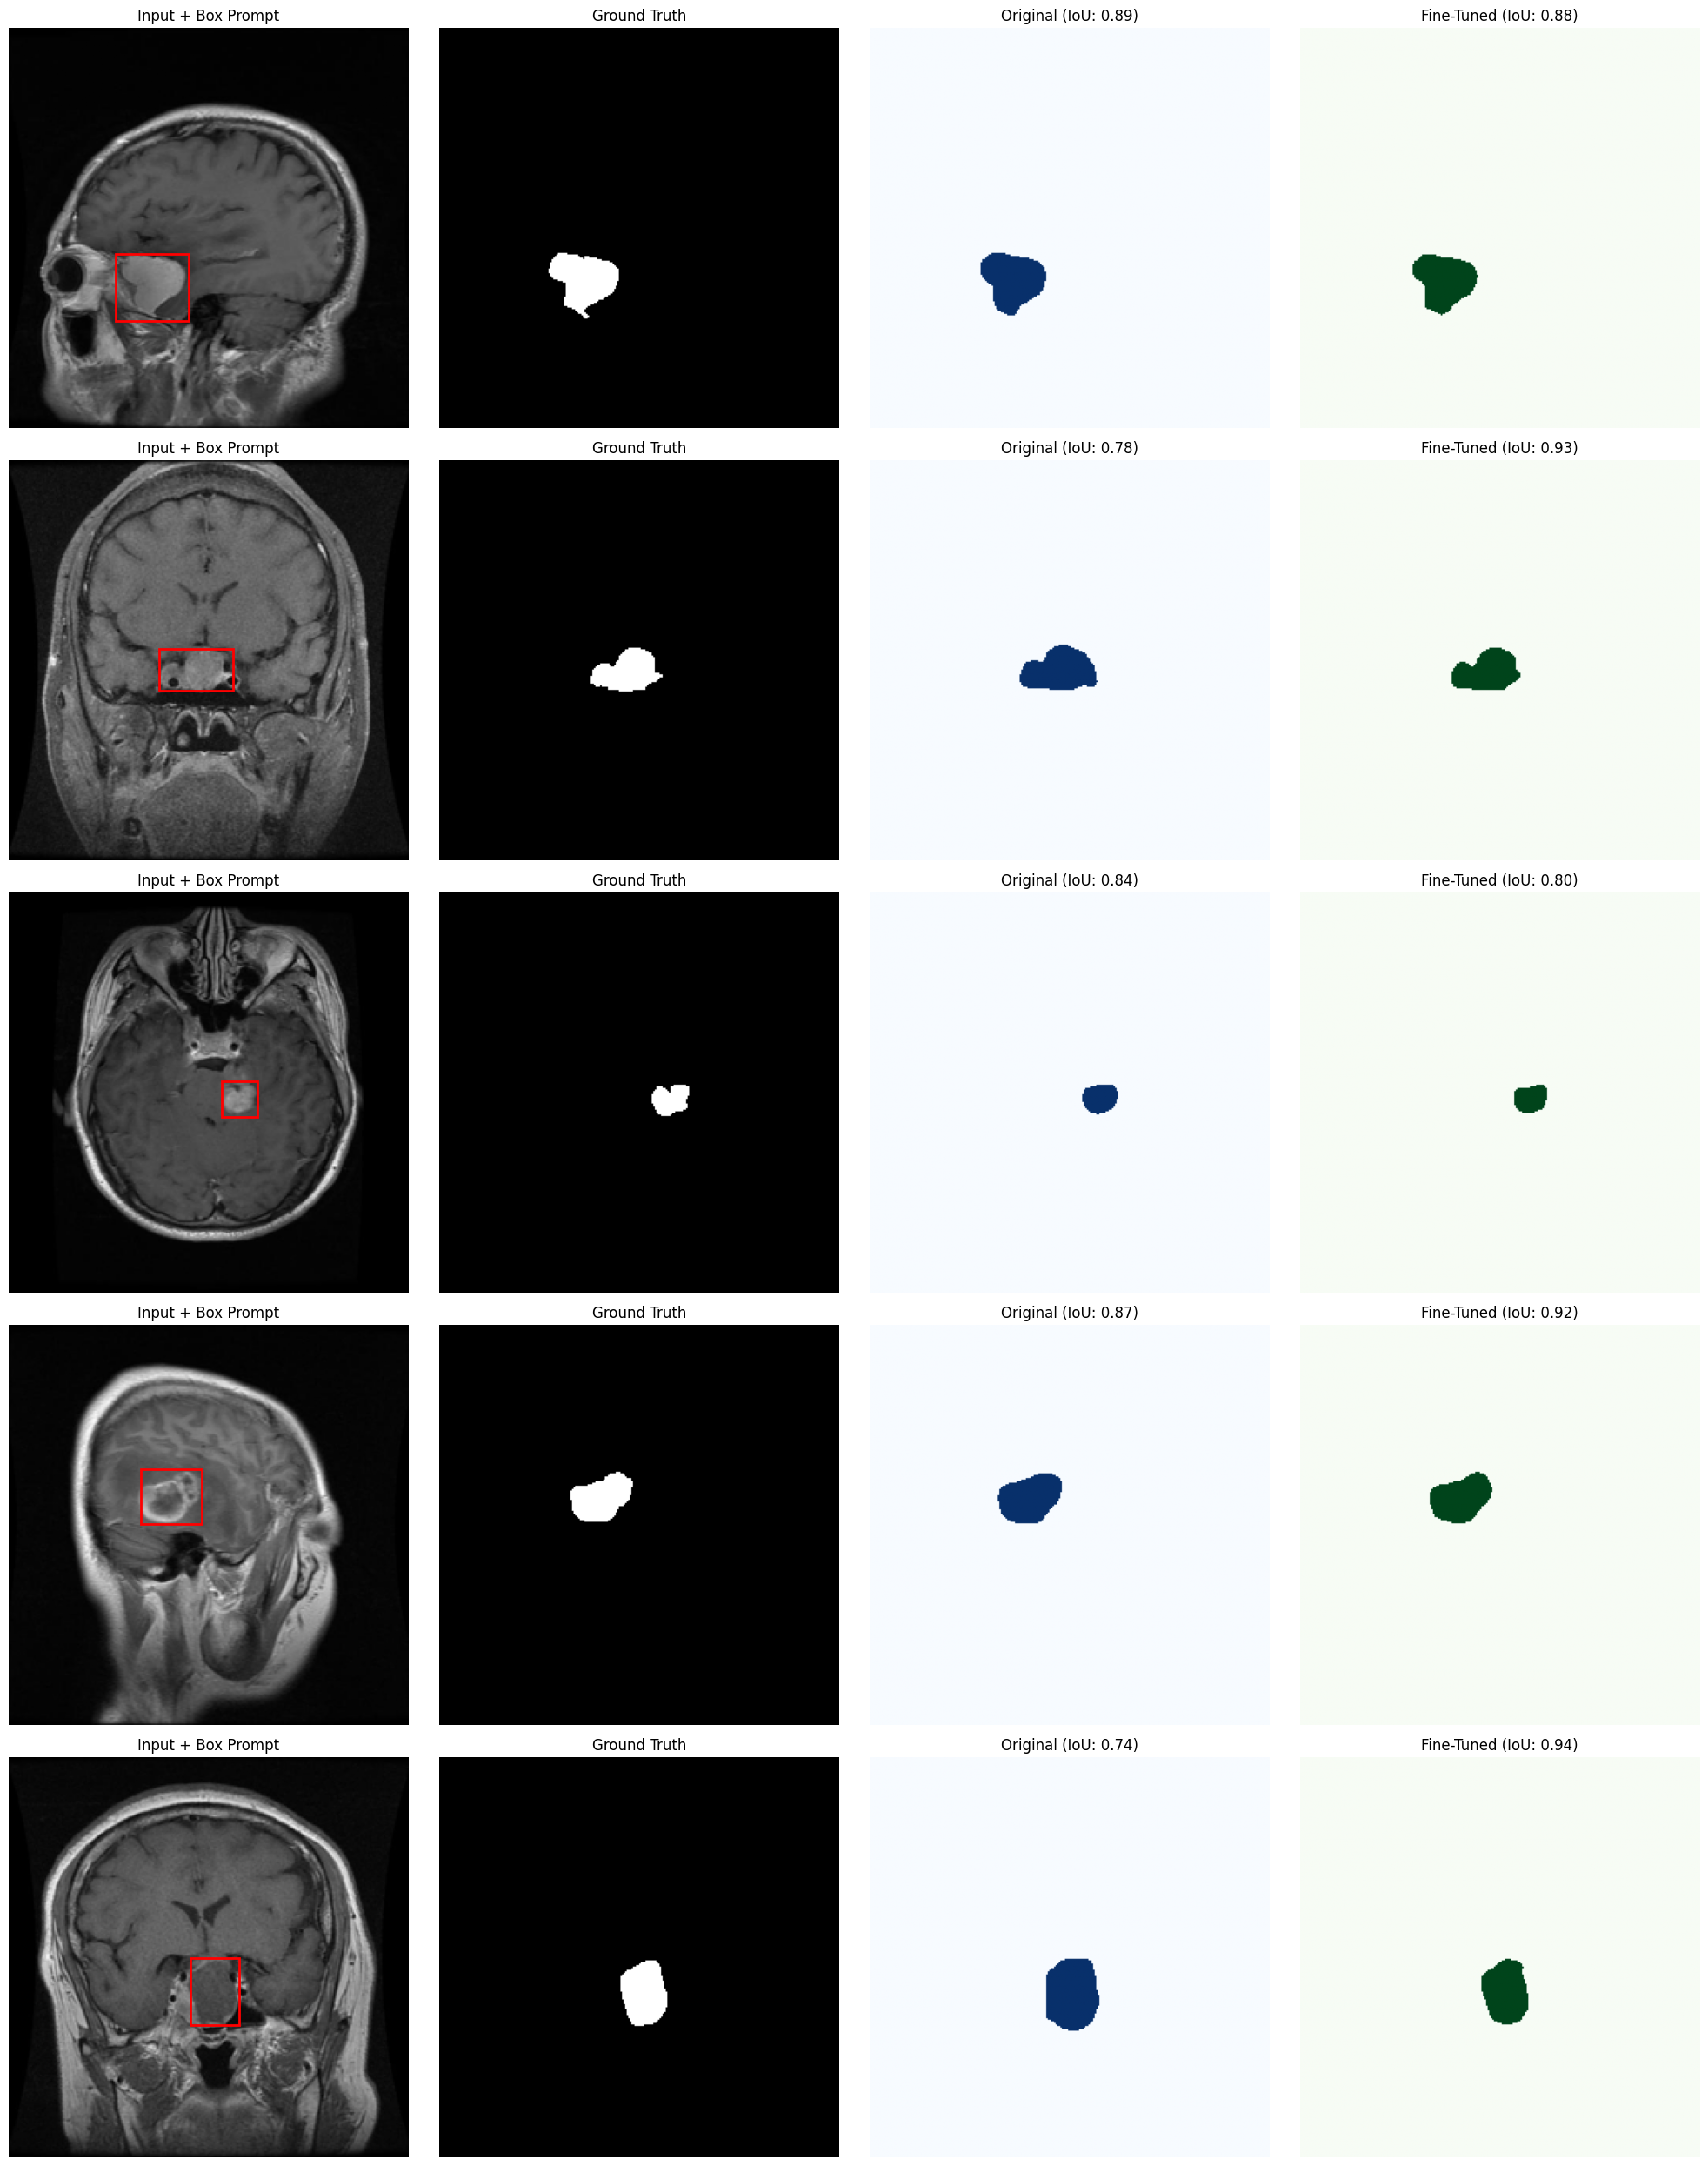

In [ ]:
def plotar_comparativo(samples):
    num_samples = len(samples)
    fig, axs = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    if num_samples == 1: axs = [axs]

    for idx, item in enumerate(samples):
        img = item['image'].permute(1, 2, 0).numpy()
        gt = item['gt'].squeeze().numpy()
        box = item['box'].numpy()
        p_orig = item['pred_orig'].squeeze().numpy()
        p_ft = item['pred_ft'].squeeze().numpy()

        # 1. Imagem + Prompt
        axs[idx][0].imshow(img)
        rect = patches.Rectangle(
            (box[0], box[1]), box[2]-box[0], box[3]-box[1],
            linewidth=2, edgecolor='red', facecolor='none'
        )
        axs[idx][0].add_patch(rect)
        axs[idx][0].set_title(f"Input + Box Prompt")
        axs[idx][0].axis('off')

        # 2. Ground Truth
        axs[idx][1].imshow(gt, cmap='gray')
        axs[idx][1].set_title("Ground Truth")
        axs[idx][1].axis('off')

        # 3. Predição Original
        axs[idx][2].imshow(p_orig, cmap='Blues')
        axs[idx][2].set_title(f"Original (IoU: {item['iou_orig']:.2f})")
        axs[idx][2].axis('off')

        # 4. Predição Fine-Tuned
        axs[idx][3].imshow(p_ft, cmap='Greens')
        axs[idx][3].set_title(f"Fine-Tuned (IoU: {item['iou_ft']:.2f})")
        axs[idx][3].axis('off')

    plt.tight_layout()
    plt.show()

plotar_comparativo(visualizacoes)

# Conclusão

## Análise dos Resultados Obtidos

A comparação entre o SAM Original (Zero-Shot) e o SAM Fine-Tuned mostrou que tivemos bons ganhos em todas as métricas avaliadas, mostrando que nossa ideia de apenas treinar o Mask Decoder funcionou, permitindo um treino mais rápido e eficaz

### Ganho de Performance (Mean IoU)

O modelo fine-tuned teve um aumento de **~9%** na média de IoU, saltando de **78.91%** para **87.75%**. Assim, temos que o modelo ajustado conseguiu delinear a área do tumor com muito mais precisão do que o modelo genérico.

### Estabilidade e Confiabilidade (Std Dev)

Um dos resultados mais importantes foi a redução do Desvio Padrão de **0.1229** para **0.07**.

* O SAM Original era levemente mais instável; ele ia bem em algumas imagens fáceis, mas errava feio em outras. O nosso SAM Fine-Tuned é consistente, entregando resultados de alta qualidade na grande maioria das amostras, o que é crítico para aplicações médicas.

### Eliminação de Falhas Perigosas (Min IoU)

A métrica de "IoU Mínimo" mostra a maior evolução (e talvez a mais importante). O pior caso do modelo original foi **28%** (basicamente errou o tumor inteiro). Já o pior caso do modelo Fine-Tuned foi **56%**.

* Logo, o fine-tuning ensinou o modelo a lidar com casos difíceis, dificilmente não capturando, pelo menos, uma boa parte do tumor. Assim, nosso modelo dificilmente falharia em capturar algo que, se não capturado, pode levar a problemas sérios.

## Análise Visual

Olhando as máscaras geradas, podemos ver:

* **Bordas:** O modelo ajustado segue as bordas irregulares dos tumores com muito mais fidelidade, enquanto o original tendia a criar formas mais arredondadas ou simplificadas.

* **Falsos Positivos:** O fine-tuning reduziu a segmentação de tecidos saudáveis adjacentes que possuem intensidade de pixel similar ao tumor.

## Desafios Técnicos Superados

1.  **Resolução:** A interpolação dos *Positional Embeddings* permitiu usar imagens de 256x256 sem quebrar a arquitetura do ViT, viabilizando o treino com recursos limitados. Como as imagens dos tumores eram de 350x350 pixels, utilizar no formato 1024x1024 original do SAM era um problema.

2.  **Congelamento:** Treinar apenas o *Mask Decoder* (menos de 10% dos pesos) provou ser suficiente e altamente eficiente, economizando tempo e memória de GPU.

3.  **Prompts Automáticos:** O uso de Bounding Boxes derivadas das máscaras de treino funcionou perfeitamente como sinalizador de atenção para o modelo.

## Por fim...

O nosso modelo SAM Fine-Tuned mostrou-se superior em todos os aspectos. A adaptação transformou uma ferramenta generalista em um assistente especialista capaz de segmentar tumores cerebrais com alta precisão média, provando o potencial do *Transfer Learning* nesse tipo de problemas.